#### imports

**functions**
- corner_detection(img, sigma) computes the locations of features
- computeBrief(img, locs) builds descriptors based the features 
- matches = briefMatch(desc1, desc2) uses the BRIEF method to build matches
- plotMatches(im1, im2, matches, locs1, locs2) plots the matches given images and locations
- display_image(image, title) displays image with title

**libraries**
- numpy, cv2 (for comparison and displaying), scipy, matplotlib

**images and videos**
- textbook cover
- textbook transform 
- harry potter cover 
- ...

In [1]:
import numpy as np
import cv2
import scipy.io as sio
import scipy 
from matplotlib import pyplot as plt
import scipy

In [2]:
from helper import briefMatch
from helper import plotMatches
from helper import computeBrief
from helper import corner_detection

In [3]:
def display_image(image, title="Image"):
    plt.figure(figsize=(10, 6))
    if len(image.shape) == 2:  # Grayscale image
        plt.imshow(image, cmap='gray')
    else:  # RGB image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(title)
    plt.axis('off')
    plt.show()

In [4]:
cv_cover = cv2.imread('../data/cv_cover.jpg')
cv_desk = cv2.imread('../data/cv_desk.png')
hp_cover = cv2.imread('../data/hp_cover.jpg')
hp_desk = cv2.imread('../data/hp_desk.png')

#### matchPics with BRIEF

Note that matchPics takes in imaging coordinates which we will change to put into our homography function that accepts euclidean coordinates

In [5]:
def matchPics(I1, I2, sigma=0.15, ratio=0.65):
	#Convert Images to GrayScale
	i1gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
	i2gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)
	
	#Detect Features in Both Images
	i1loc = corner_detection(i1gray, sigma)
	i2loc = corner_detection(i2gray, sigma)
	
	#Obtain descriptors for the computed feature locations
	desc1, locs1 = computeBrief(i1gray, i1loc)
	desc2, locs2 = computeBrief(i2gray, i2loc)
	

	#Match features using the descriptors
	matches = briefMatch(desc1, desc2, ratio)

	return matches, locs1, locs2

##### testing

[164 248]


/Users/stephanieyang/Desktop/16385/homographysource/python/helper.py:21: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  skimage.feature.plot_matches(ax, im1, im2, locs1, locs2, matches, matches_color='r', only_matches=True)


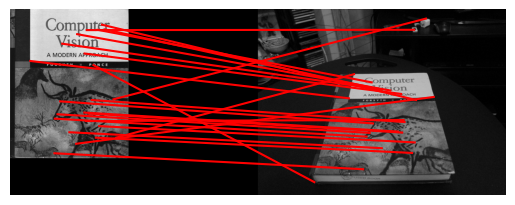

In [6]:
sig = 0.2
rat = 0.75
matches, locs1, locs2 = matchPics(cv_cover, cv_desk, sig, rat)
print(locs1[1])

#display matched features
plotMatches(cv_cover, cv_desk, matches, locs1, locs2)

##### analysis with BRIEF
We can observe that BRIEF performs poorly with rotations due to its binary application that is unable to detect matches when faced with these changes. 

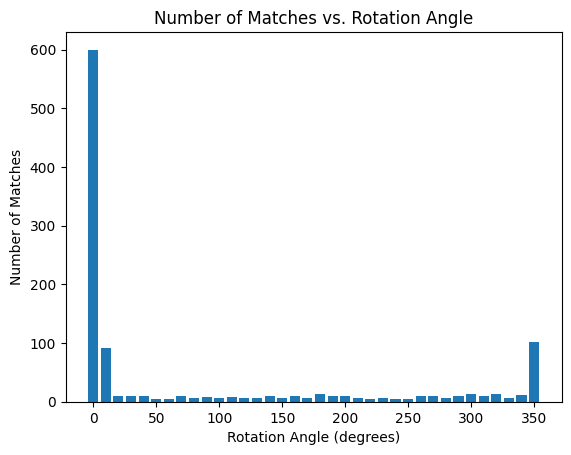

In [7]:
img = cv_cover

num_matches = []
for i in range(36):
	#Rotate Image
    angle = i * 10
    rotated = scipy.ndimage.rotate(img, angle)
	
	#Compute features, descriptors and Match features
    matches, locs1, locs2 = matchPics(img, rotated, sig, rat)
    #print("i, match", i, len(matches))

	#Update histogram
    num_matches.append(len(matches))

angles = np.arange(0, 360, 10)
plt.bar(angles, num_matches, width=8)  # width sets the width of the bars
plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Number of Matches')
plt.title('Number of Matches vs. Rotation Angle')

plt.show()

#### computeHomography
Utilizes RANSAC which we will use to compare to cv2.findHomography using the cv2.RANSAC algorithm. We make sure to use DLT which is utilized in cv2.findHomography.

In [8]:
def computeH(x1, x2):
    """
    Estimates the homography between two sets of points using the Direct Linear Transform (DLT).
    
    Args:
    x1: (N x 2) array containing the (x, y) coordinates of points in image 1.
    x2: (N x 2) array containing the (x, y) coordinates of corresponding points in image 2.
    
    Returns:
    H2to1: (3 x 3) Homography matrix
    """
    
    N = x1.shape[0]
    A = []
    
    for i in range(N):
        x_1, y_1 = x1[i]
        x_2, y_2 = x2[i]
        A.append([-x_2, -y_2, -1, 0, 0, 0, x_2 * x_1, y_2 * x_1, x_1])
        A.append([0, 0, 0, -x_2, -y_2, -1, x_2 * y_1, y_2 * y_1, y_1])

    A = np.array(A)
    
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1, :].reshape(3, 3)
    H2to1 = H / H[2, 2]
    
    return H 


In [9]:
def computeH_norm(x1, x2):
    """
    Normalizes points, computes the homography, and denormalizes the result.
    
    Args:
    x1: (N x 2) array containing the (x, y) coordinates of points in image 1.
    x2: (N x 2) array containing the (x, y) coordinates of corresponding points in image 2.
    
    Returns:
    H2to1: (3 x 3) Homography matrix with normalization.
    """
    
    def normalize_points(points):
        centroid = np.mean(points, axis=0)
        points_centered = points - centroid
        scale = np.sqrt(2) / np.mean(np.linalg.norm(points_centered, axis=1))
        
        T = np.array([[scale, 0, -scale * centroid[0]],
                      [0, scale, -scale * centroid[1]],
                      [0, 0, 1]])
        
        points_h = np.hstack([points, np.ones((points.shape[0], 1))])
        points_normalized = (T @ points_h.T).T
        
        return points_normalized[:, :2], T
    
    # Normalize both sets of points
    x1_norm, T1 = normalize_points(x1)
    x2_norm, T2 = normalize_points(x2)
    
    # Compute the homography with normalized points
    H_norm = computeH(x1_norm, x2_norm)
    
    # Denormalize the homography
    H2to1 = np.linalg.inv(T1) @ H_norm @ T2
    
    return H2to1 


In [10]:
def computeH_ransac(x1, x2, max_iters=1000, tol=1):
    """
    Estimates the homography using RANSAC.
    
    Args:
    x1: (N x 2) array containing the (x, y) coordinates of points in image 1.
    x2: (N x 2) array containing the (x, y) coordinates of corresponding points in image 2.
    max_iters: Maximum number of iterations.
    tol: Inlier tolerance for reprojection error.
    
    Returns:
    bestH2to1: (3 x 3) Homography matrix with the most inliers.
    inliers: (N,) binary array indicating which points are inliers.
    """
    
    N = x1.shape[0]
    bestH2to1 = None
    max_inliers = 0
    best_inliers = None
    
    for _ in range(max_iters):
        # Randomly sample 4 points
        idxs = np.random.choice(N, 4, replace=False)
        H = computeH(x1[idxs], x2[idxs])
        
        # Compute the projected points using H
        x2_h = np.hstack([x2, np.ones((N, 1))])
        x2_proj = (H @ x2_h.T).T
        x2_proj = x2_proj[:, :2] / x2_proj[:, 2][:, np.newaxis]
        
        # Compute reprojection error
        errors = np.linalg.norm(x1 - x2_proj, axis=1)
        inliers = errors < tol
        num_inliers = np.sum(inliers)
        
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            bestH2to1 = H
            best_inliers = inliers
    
    return bestH2to1, best_inliers.astype(int)


##### small example testing

In [25]:
src = np.array([[14,28], [288,28], [14,218], [288,218]])
dst = np.array([[34,207], [281,130], [16,29], [263,25]])

bestH2to1, inliers = computeH_ransac(src, dst, 100,0.1)
print(bestH2to1)
print(inliers)

[[ 2.54247354e-03 -2.41433646e-04  2.15291761e-02]
 [-1.44901193e-03 -4.03134481e-03  9.99747805e-01]
 [-6.31889697e-06  1.75830532e-06  3.99348129e-03]]
[1 1 1 1]


In [12]:
cv2.findHomography(dst, src, cv2.RANSAC)

(array([[ 6.36655930e-01, -6.04569368e-02,  5.39107975e+00],
        [-3.62844303e-01, -1.00948133e+00,  2.50344933e+02],
        [-1.58230289e-03,  4.40293867e-04,  1.00000000e+00]]),
 array([[1],
        [1],
        [1],
        [1]], dtype=uint8))

#### final results

In [13]:
matches, locs1, locs2 = matchPics(cv_cover, cv_desk, 0.23, 0.9)

locs1 = locs1[:, [1, 0]]  # Swap columns (y, x) -> (x, y)
locs2 = locs2[:, [1, 0]]

matched_points1 = locs1[matches[:, 0]]  # Points from cv_cover
matched_points2 = locs2[matches[:, 1]]
print(len(matched_points1), len(matched_points2))

41 41


In [14]:
bestH2to1, i = computeH_ransac(matched_points2, matched_points1, 10000, 5)
print(bestH2to1)
print(i)

[[-2.20737575e-03  1.15370058e-03 -7.81913040e-01]
 [ 1.35065085e-04 -6.74019395e-04 -6.23373913e-01]
 [ 2.67770798e-07  3.04198788e-06 -3.20741205e-03]]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1
 1 0 0 1]


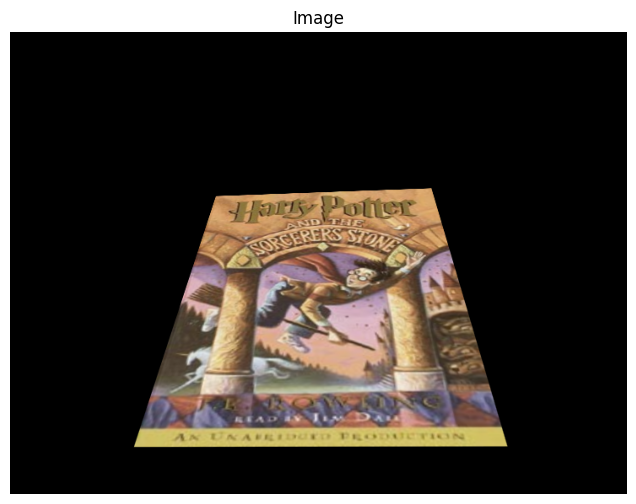

In [17]:
h_desk, w_desk, _ = cv_desk.shape
h_cover, w_cover, _ = cv_cover.shape
resized_hp_cover = cv2.resize(hp_cover, (w_cover, h_cover))
warped_hp_cover = cv2.warpPerspective(resized_hp_cover, bestH2to1, (w_desk, h_desk))

display_image(warped_hp_cover)

In [18]:
def compositeH(H, template, img):
    """
    Composite the warped template with the image using the homography H.
    """
    h, w = img.shape[:2]
    
    # Warp the template image to align with the image
    warped_template = cv2.warpPerspective(template, H, (w, h))
    
    # Create a mask where the warped image is not black
    mask = np.sum(warped_template, axis=2) > 0
    mask = mask.astype(np.uint8)

    # Use the mask to blend the images
    img_masked = img * (1 - mask[:, :, np.newaxis])
    composite_img = img_masked + warped_template

    return composite_img

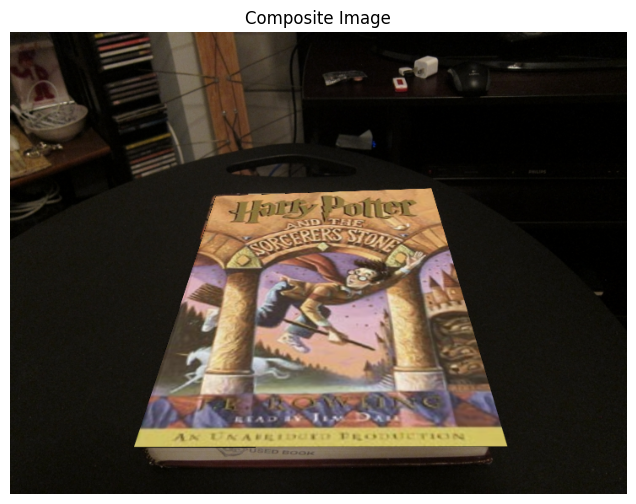

In [19]:
composite_img = compositeH(bestH2to1, resized_hp_cover, cv_desk)
display_image(composite_img, "Composite Image")

##### comparing to cv2.findhomography using our matchPics algorithm

Might perform better with ORB or some other descriptor algorithm.

In [16]:
# asserting correctness with cv2
cvh, cvi = cv2.findHomography(matched_points1, matched_points2, cv2.RANSAC, 5)
print(cvh)

[[ 7.47427617e-01 -3.46008530e-01  2.38361764e+02]
 [-8.22510720e-03  2.29159582e-01  1.91871593e+02]
 [-5.02947266e-07 -9.15816654e-04  1.00000000e+00]]


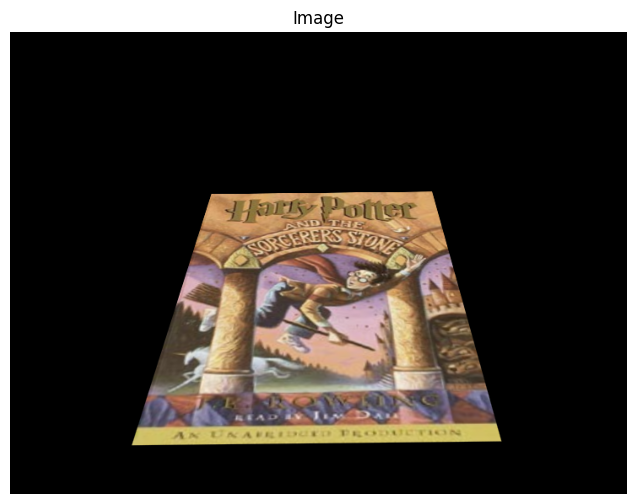

In [20]:
h_desk, w_desk, _ = cv_desk.shape
h_cover, w_cover, _ = cv_cover.shape
resized_hp_cover = cv2.resize(hp_cover, (w_cover, h_cover))
warped_hp_cover = cv2.warpPerspective(resized_hp_cover, cvh, (w_desk, h_desk))

display_image(warped_hp_cover)

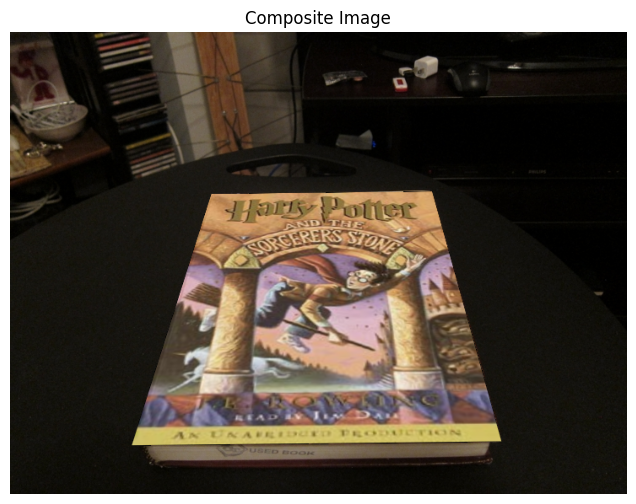

In [21]:
composite_img = compositeH(cvh, resized_hp_cover, cv_desk)
display_image(composite_img, "Composite Image")